# Decision Trees and Ensemble Learning

This notebook covers decision trees and tree-based ensemble algorithms for machine learning.

## Learning Objectives

By the end of this notebook, you will:
- Understand how decision trees work and learn to train them
- Learn about overfitting and how to control tree complexity
- Explore the decision tree learning algorithm
- Tune decision tree parameters
- Build random forest models
- Implement gradient boosting with XGBoost
- Select the best model for production

## Credit Risk Scoring Project

### Project Overview

In this project, we'll build a credit risk scoring model using decision trees and ensemble methods. The goal is to predict whether a customer will default on their credit.

### Dataset

- **Source**: [CreditScoring Dataset](https://github.com/gastonstat/CreditScoring)
- **Task**: Binary classification (predicting default vs. no default)
- **Features**: Customer attributes such as income, assets, job type, marital status, etc.

## Import Required Libraries

We'll start by importing the necessary libraries for data manipulation, visualization, and machine learning.


In [23]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Data Cleaning and Preparation

In this section, we will:
- Download and load the dataset
- Clean and preprocess the data
- Encode categorical variables
- Handle missing values
- Split the data into training, validation, and test sets

### Download and Load the Dataset

Let's download and examine the dataset structure.

In [24]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [25]:
!wget $data

--2025-11-02 14:05:23--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.1’

CreditScoring.csv.1 100%[===================>] 178.21K  --.-KB/s    in 0.007s  

2025-11-02 14:05:23 (25.7 MB/s) - ‘CreditScoring.csv.1’ saved [182489/182489]



In [26]:
!head CreditScoring.csv

"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


In [27]:
df = pd.read_csv(data)

### Standardize Column Names

We'll convert all column names to lowercase for consistency.


In [28]:
# Convert all column names to lowercase for consistency
df.columns = df.columns.str.lower()

### Encode Categorical Variables

The dataset uses numeric codes for categorical variables. We'll convert these to descriptive text labels for better interpretability.


In [29]:
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [30]:
# To make the dataset easier to interpret, we’ll convert these numeric codes into descriptive text labels.
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

### Handle Missing Values

Some columns contain extremely large numbers (99999999) that represent missing data. We'll replace these with NaN values.


In [31]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [32]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [33]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


We notice that some columns — such as **income**, **assets**, and **debt** — contain extremely large numbers.

These values actually represent **missing data** and should be replaced with `NaN`.

We can replace them as follows:

In [34]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [35]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


For the **status** column, some rows have the value **“unknown”**, which isn’t useful for modeling.

We’ll remove those rows:

In [36]:
df = df[df.status != 'unk'].reset_index(drop=True)

With the dataset cleaned, we’ll create training, validation, and test sets

### Prepare Target Variables

We'll create binary target variables (1 for default, 0 for ok) for each split and remove the status column from the feature sets.


In [37]:
from sklearn.model_selection import train_test_split

# Split off 20% for testing
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)

# Split the remaining 80% into training and validation sets
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [38]:
# Reset indices for clarity
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

The **status** column (which we converted to text earlier) is our target variable.

We’ll now convert it back into binary numbers for modeling:

* **1** → if the customer **defaulted**
* **0** → otherwise

In [39]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

After creating the target variables, we remove the **status** column from the feature dataframes:

In [40]:
del df_train['status']
del df_val['status']
del df_test['status']

In [41]:
df_train

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,18,private,36,45,married,no,fixed,45,220.0,20000.0,0.0,800,1600
2668,7,private,60,29,married,no,fixed,60,51.0,3500.0,500.0,1000,1290
2669,1,parents,24,19,single,no,fixed,35,28.0,0.0,0.0,400,600
2670,15,owner,48,43,married,no,freelance,60,100.0,18000.0,0.0,2500,2976


## Decision Trees

In this section, we'll learn about:
- What decision trees are and how they work
- How to train a decision tree model
- Understanding overfitting in decision trees
- Controlling tree size to prevent overfitting

### Introduction to Decision Trees

Decision trees learn if-then-else rules from data automatically. Let's start with a simple example.

Imagine a few simple rules:

* If a customer **has credit records**, check whether their **job is part-time**.
	* If yes → predict **default**.
	* If no → predict **ok**.
* If the customer **doesn’t have credit records**, check if their **assets > 6000**.
	* If yes → predict **ok**.
	* If no → predict **default**.

This structure can also be written as nested `if-else` statements in Python. A decision tree algorithm automatically learns these rules from data.

In [42]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [43]:
xi = df_train.iloc[0].to_dict()

In [44]:
assess_risk(xi)

'ok'

To train a decision tree model, we use **Scikit-Learn**.

Since our dataset contains categorical features, we also need a **Dictionary Vectorizer** to convert them into numerical form.


In [45]:
# Use Scikit-Learn to train a decision tree model
from sklearn.tree import DecisionTreeClassifier

# Use a Dictionary Vectorizer to convert categorical features into numerical form
from sklearn.feature_extraction import DictVectorizer

# Use the ROC AUC score to evaluate the model's performance
from sklearn.metrics import roc_auc_score

# Use the export_text function to print the decision tree rules
from sklearn.tree import export_text

In [46]:
# Fill missing values with 0 and convert the dataframe to a dictionary
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [47]:
# Create a Dictionary Vectorizer to convert the dictionary into a numerical matrix
dv = DictVectorizer(sparse=False)

# Convert the training dictionary into a numerical matrix
X_train = dv.fit_transform(train_dicts)

In [48]:
# Train a decision tree model
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

We test the model on the **validation dataset**:

In [51]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)
y_pred = dt.predict_proba(X_val)[:, 1]

To measure performance, we calculate the **AUC score (Area Under the ROC Curve)**:

In [52]:
roc_auc_score(y_val, y_pred)

np.float64(0.6589511031459641)

In [53]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

np.float64(1.0)


* **Training AUC:** 1.0 (perfect score)
* **Validation AUC:** 0.65 (much lower)

This big difference shows that the model **overfits**.

### Understanding Overfitting

**Overfitting** happens when a model learns the training data too well — including its noise and specific details — instead of learning general patterns.

#### Controlling Tree Depth

To prevent overfitting, we can **limit the maximum depth** of the tree.

Let’s retrain the model with a smaller depth:

In [54]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [55]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7054989859726213
val: 0.6685264343319367


We can see that the model performs better on the validation set.

To get a better understanding of the model's rules, we can print the tree:

In [56]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



## Decision Tree Learning Algorithm

This section explains how decision trees learn from data:
- Finding the best split for a single feature
- Finding the best split across all features
- Measuring split quality using impurity metrics
- Understanding stopping criteria
- The complete learning algorithm

### Finding the Best 

#### Single Feature Example

Let’s start with a simple dataset containing two columns:

* **assets** – the amount of money a customer owns
* **status** – whether the customer defaulted or not

We want to find the best threshold `T` for splitting based on the `assets` column.

We can try thresholds at several values, for example:

`2000, 3000, 4000, 5000, 8000`

For each threshold:

* Customers with `assets <= T` go to the **left** group.
* Customers with `assets > T` go to the **right** group.

Then, we measure how well each split separates the two classes (default vs ok).

In [57]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [58]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
4,5000,ok
3,5000,ok
0,8000,default
6,9000,ok


### Measuring Split Quality: Misclassification Rate (Impurity)

To evaluate a split, we calculate how “pure” each group is using **impurity metrics**.

One simple impurity measure is the **misclassification rate** — the fraction of records in a group that belong to the minority class.

For example:

If a group has **3 defaults** and **1 ok**, we predict **“default”** for this group (the majority class).

The misclassification rate = 1 / 4 = **25%**

We repeat this for both the left and right groups, then compute the **average impurity** of the split.

The best threshold is the one with the **lowest average impurity** — the most effective at separating the two classes.

In [59]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [66]:
from IPython.display import display

This imports the `display()` function, which is used in Jupyter notebooks to show pandas DataFrames in a nice, formatted way (similar to how `.head()` outputs look).

In [64]:
T = 4000
df_left = df_example[df_example.assets <= T]
df_right = df_example[df_example.assets > T]

# Calculate the impurity for each split
display(df_left)
impurity_left = df_left.status.value_counts(normalize=True)
print(impurity_left)

display(df_right)
impurity_right = df_right.status.value_counts(normalize=True)
print(impurity_right)

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64


In [68]:
from IPython.display import display

# Initialize variables to keep track of the best (lowest) impurity
best_t = None          # best threshold value
best_impurity = 1.0    # start with maximum possible impurity (100%)

# Loop through each threshold value T from the list Ts
for T in Ts:
    print(f"Threshold: {T}")
    
    # Split the dataset into left and right subsets
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    # Display both subsets (optional for visual inspection)
    display(df_left)
    display(df_right)
    
    # Calculate misclassification rate (impurity) for left side
    left_counts = df_left.status.value_counts(normalize=True)
    impurity_left = 1 - left_counts.max()  # 1 - majority class proportion
    
    # Calculate misclassification rate (impurity) for right side
    right_counts = df_right.status.value_counts(normalize=True)
    impurity_right = 1 - right_counts.max()
    
    # Compute weighted average impurity for this split
    n_left = len(df_left)
    n_right = len(df_right)
    total = n_left + n_right
    avg_impurity = (n_left / total) * impurity_left + (n_right / total) * impurity_right

    # Print impurity values for inspection
    print(f"Impurity (Left): {impurity_left:.2f}, (Right): {impurity_right:.2f}, (Average): {avg_impurity:.2f}\n")

    # Update best split if this one has lower impurity
    if avg_impurity < best_impurity:
        best_impurity = avg_impurity
        best_t = T

# After the loop, print the best threshold and its impurity
print("=" * 50)
print(f"Lowest impurity: {best_impurity:.2f} at threshold T = {best_t}")


Threshold: 0


,assets,status
2,0,default


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


Impurity (Left): 0.00, (Right): 0.43, (Average): 0.38

Threshold: 2000


,assets,status
1,2000,default
2,0,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


Impurity (Left): 0.00, (Right): 0.33, (Average): 0.25

Threshold: 3000


,assets,status
1,2000,default
2,0,default
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


Impurity (Left): 0.00, (Right): 0.20, (Average): 0.12

Threshold: 4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


Impurity (Left): 0.25, (Right): 0.25, (Average): 0.25

Threshold: 5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


,assets,status
0,8000,default
6,9000,ok


Impurity (Left): 0.50, (Right): 0.50, (Average): 0.50

Threshold: 8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


,assets,status
6,9000,ok


Impurity (Left): 0.43, (Right): 0.00, (Average): 0.38

Lowest impurity: 0.12 at threshold T = 3000


The best threshold is the one with the **lowest average impurity** — the most effective at separating the two classes.

In our example, the best split was at **assets = 3000**, which had the lowest impurity (10%).

### Adding Another Feature

Now let’s add a second feature: **debt**.

We repeat the same process for this feature, trying thresholds such as **500, 1000, and 2000**.

For each feature and each threshold, we:

1. Split the dataset into left and right groups.
2. Calculate the impurity on both sides.
3. Compute the average impurity.

After evaluating all splits, we select the one with the **lowest impurity**.

In [69]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [70]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
3,5000,1000,ok
2,0,1000,default
5,4000,1000,ok
4,5000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [71]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

The cell below:

1. Iterates through both features (`assets` and `debt`).
2. For each threshold:

	 * Splits data into left/right.
	 * Calculates **misclassification rate** (impurity) for each side.
	 * Computes **weighted average impurity**.
3. Keeps track of the **lowest impurity** and corresponding feature/threshold.
4. Prints the **best split** at the end.

In [72]:
# Variables to keep track of the best split overall
best_feature = None
best_t = None
best_impurity = 1.0  # start with the highest possible impurity

# Loop through each feature and its threshold list
for feature, Ts in thresholds.items():
    print('###############################')
    print(f"Feature: {feature}")

    # Loop through all possible thresholds for the current feature
    for T in Ts:
        print(f"Threshold: {T}")

        # Split the dataset into two groups based on the threshold
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        # Skip invalid splits (one of the sides empty)
        if len(df_left) == 0 or len(df_right) == 0:
            continue

        # Calculate impurity (misclassification rate) for left subset
        left_counts = df_left.status.value_counts(normalize=True)
        impurity_left = 1 - left_counts.max()

        # Calculate impurity for right subset
        right_counts = df_right.status.value_counts(normalize=True)
        impurity_right = 1 - right_counts.max()

        # Compute weighted average impurity
        n_left = len(df_left)
        n_right = len(df_right)
        total = n_left + n_right
        avg_impurity = (n_left / total) * impurity_left + (n_right / total) * impurity_right

        # Print impurity info for transparency
        print(f"Impurity (Left): {impurity_left:.2f}, (Right): {impurity_right:.2f}, (Average): {avg_impurity:.2f}\n")

        # Check if this is the best (lowest impurity) split so far
        if avg_impurity < best_impurity:
            best_impurity = avg_impurity
            best_t = T
            best_feature = feature

    print('###############################')

# Print the final best split result
print("=" * 60)
print(f"Best split found:")
print(f"- Feature: {best_feature}")
print(f"- Threshold: {best_t}")
print(f"- Lowest impurity: {best_impurity:.2f}")
print("=" * 60)


###############################
Feature: assets
Threshold: 0
Impurity (Left): 0.00, (Right): 0.43, (Average): 0.38

Threshold: 2000
Impurity (Left): 0.00, (Right): 0.33, (Average): 0.25

Threshold: 3000
Impurity (Left): 0.00, (Right): 0.20, (Average): 0.12

Threshold: 4000
Impurity (Left): 0.25, (Right): 0.25, (Average): 0.25

Threshold: 5000
Impurity (Left): 0.50, (Right): 0.50, (Average): 0.50

Threshold: 8000
Impurity (Left): 0.43, (Right): 0.00, (Average): 0.38

###############################
###############################
Feature: debt
Threshold: 500
Impurity (Left): 0.00, (Right): 0.43, (Average): 0.38

Threshold: 1000
Impurity (Left): 0.33, (Right): 0.00, (Average): 0.25

Threshold: 2000
Impurity (Left): 0.43, (Right): 0.00, (Average): 0.38

###############################
Best split found:
- Feature: assets
- Threshold: 3000
- Lowest impurity: 0.12


## Decision Tree Parameter Tuning

In this section, we'll tune decision tree hyperparameters to find the best model configuration and prevent overfitting.


### Recursively Building the Tree

Once we find the best split, the data is divided into two groups: **left** and **right**.

We then **repeat** the same process for each of these groups, splitting them further until certain stopping conditions are met.

This recursive process continues until the tree is complete.

### Stopping Criteria

To prevent the tree from growing endlessly (and overfitting), we define stopping conditions. The algorithm stops splitting when any of the following is true:

1. **The group is pure.**
	* All records belong to the same class (impurity = 0).
2. **The maximum depth is reached.**
	* Controlled by the `max_depth` parameter.
3. **The group is too small to split.**
	* If the group has fewer than a set number of records, we stop.

By applying these rules, we keep the model simpler and prevent overfitting.

### Understanding Key Parameters

Scikit-learn’s `DecisionTreeClassifier` includes many parameters, such as:

* `criterion` – the measure of impurity (e.g., “gini”, “entropy”).
* `max_depth` – limits the number of layers in the tree.
* `min_samples_leaf` – defines the minimum samples per leaf node (a decision leaf where the final prediction occurs).

While there are many options, we’ll focus on **`max_depth`** and **`min_samples_leaf`**, as they are the most influential.

#### Tuning `max_depth`

We start by testing different values of `max_depth` to see how deep the tree should grow before it overfits.

We’ll train several models with depths such as:

`1, 2, 3, 4, 5, 6, 10, 15, 20, None` (where `None` means unlimited depth).

For each model:

1. Train the decision tree on the training set.
2. Predict probabilities on the validation set.
3. Calculate the **AUC (Area Under ROC Curve)**.
4. Compare results across different depths.

In [73]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.767
   6 -> 0.749
  10 -> 0.687
  15 -> 0.666
  20 -> 0.662
None -> 0.667


After evaluating, we observe that:

* The best AUC is around **0.76**.
* Depth values between **4 and 6** perform similarly well.

Choosing a **shallower tree (depth = 4)** is often preferred since it’s simpler, easier to interpret, and less prone to overfitting.


#### Tuning `min_samples_leaf`

Next, we tune **`min_samples_leaf`** while keeping `max_depth` fixed at its best range (4–6).

This parameter ensures that a leaf must contain at least a certain number of samples before becoming a final decision node.

We’ll test values such as:

`1, 2, 5, 10, 15, 20, 100, 200, 500`.

For each combination of `max_depth` and `min_samples_leaf`:

* Train the tree.
* Predict on the validation set.
* Compute AUC and record the results.

In [74]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

#### Analyzing Results

To compare results more effectively, we store them in a **DataFrame** with columns as follows:

In [78]:
# Converts the results list into a pandas DataFrame for easier analysis
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

We then:

* Sort by AUC (descending).
* Identify the best-performing parameter combination.

To visualize this, we create a **pivot table**:

* **Rows:** `min_samples_leaf`
* **Columns:** `max_depth`
* **Values:** AUC

In [76]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.767  0.752
5                 0.761  0.768  0.760
10                0.761  0.762  0.778
15                0.764  0.772  0.785
20                0.761  0.774  0.774
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

#### Visualizing Results

After rounding AUC scores for readability, we use Seaborn’s `heatmap()`:

```python
import seaborn as sns
sns.heatmap(df_pivot, annot=True, fmt=".3f")
```

The lightest (brightest) cell corresponds to the **best AUC**, where:

* `min_samples_leaf = 15`
* `max_depth = 6`

However, tuning parameters sequentially (first `max_depth`, then `min_samples_leaf`) might **not always yield the GLOBAL OPTIMUM**.

Ideally, you’d test **all combinations**, but that’s computationally expensive for large datasets.

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

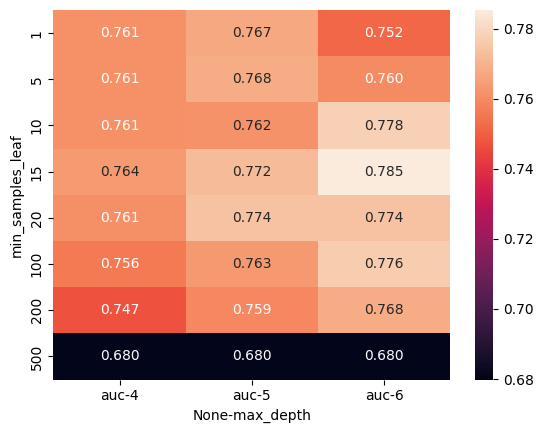

In [79]:
# Visualizing with a Heatmap
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

We find that **slightly larger trees** with **higher leaf sample limits** tend to perform better — for example, a depth of **6** and `min_samples_leaf = 15` yields good performance.

This combination prevents the model from over-splitting on small sample groups, which reduces overfitting.

In [80]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [81]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- price <= 925.00
|   |   |   |   |--- amount <= 525.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- amount >  525.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- price >  925.00
|   |   |   |   |--- price <= 1382.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- price >  1382.00
|   |   |   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- assets <= 8250.00
|   |   |   |   |--- job=fixed <= 0.50
|   |   |   |   |   |--- assets <= 3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- assets >  3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- job=fixed >  0.50
|   |   |   |   |   |--- age <= 31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- age >  31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  8250.00
|   |   |   |   |--- income <= 132.50
|   |   |   |   |   |--- class: 1
|

## Ensembles and Random Forest

In this section, we'll explore:
- The concept of ensemble learning (combining multiple models)
- Random forests as an ensemble of decision trees
- How random forests work and why they're effective
- Tuning random forest parameters

Instead of relying on a single model, we can combine predictions from multiple models to get better results.

### Understanding Random Forests

If each “expert” model is a **decision tree**, their collection forms a **Random Forest**.

However, if we simply train several identical trees on the same data, they’ll all produce the same results — making the ensemble redundant.

To avoid this, Random Forest introduces **randomness** in two main ways:

1. **Random Subsets of Features:** Each tree sees only a random subset of all available features.
2. **Random Subsets of Data (Rows):** Each tree is trained on a random subset of the dataset (using a technique called *bootstrap sampling*).

For example, suppose we have three features — **assets**, **debt**, and **price**.

We can train three decision trees as follows:

* Tree 1: trained on **assets** and **debt**
* Tree 2: trained on **assets** and **price**
* Tree 3: trained on **debt** and **price**

Each tree gives its prediction. The Random Forest then **averages** these predictions to produce the final result.

This randomness ensures that trees are **diverse**, so when combined, their errors tend to cancel out.

To build a Random Forest, we import it from Scikit-Learn’s ensemble module:

In [83]:
from sklearn.ensemble import RandomForestClassifier

We can train a Random Forest with 10, 50, 100, 200, 500, or 1000 trees:

In [84]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)  # `n_estimators` is the number of trees in the forest
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

Because each tree is trained with random data and features, the model will produce slightly different results every time it’s retrained.

To make results reproducible, we can fix the random seed:

```python
rf = RandomForestClassifier(random_state=1)
```

This ensures that we get the **same results** every time the model is trained.

In [85]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

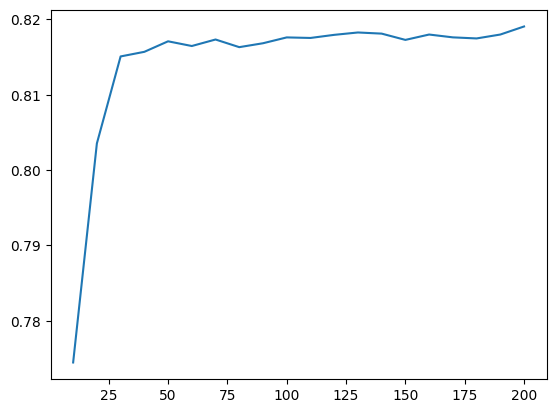

In [86]:
plt.plot(df_scores.n_estimators, df_scores.auc)

### Tuning Random Forest Parameters

Random Forests are built from multiple decision trees, so they share similar hyperparameters.

The two most important ones are:

1. **`max_depth`** – how deep each tree can grow.
2. **`min_samples_leaf`** – the minimum number of samples required in a leaf node.

We can tune these parameters just like we did for decision trees, by looping over values and checking which combination gives the highest AUC.

For example:

* Testing `max_depth = [5, 10, 15]`
* Testing `min_samples_leaf = [1, 3, 5, 10, 50]`


In [87]:
scores = []

# Loop over possible values for max_depth
for d in [5, 10, 15]:
    # Loop over number of trees (estimators)
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [88]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

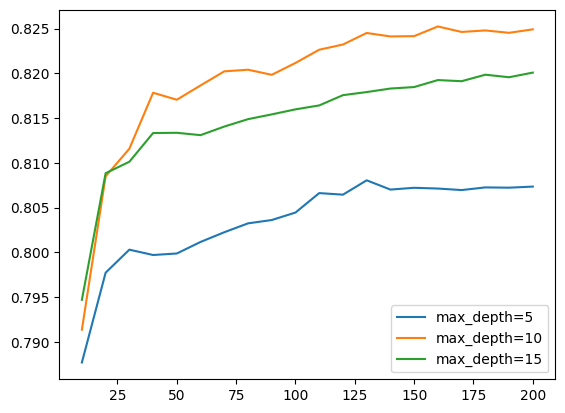

In [89]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [90]:
max_depth = 10

In [91]:
scores = []

# Loop over possible values for min_samples_leaf
for s in [1, 3, 5, 10, 50]:
    # Loop over number of trees (estimators)
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [92]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

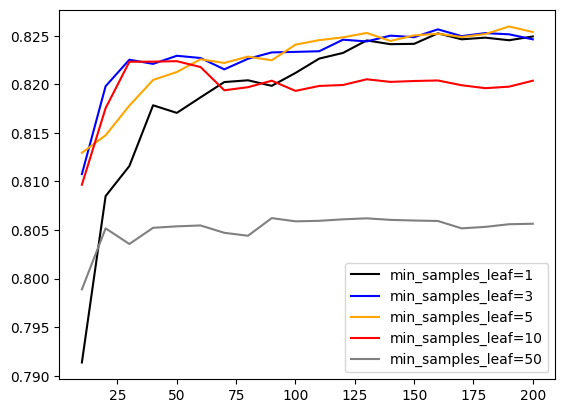

In [93]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

Through experimentation, we might find that:

* `max_depth = 10` performs best overall.
* `min_samples_leaf = 3` gives strong, stable results.

This combination usually yields a model that’s both accurate and efficient.

In [94]:
min_samples_leaf = 3

## Gradient Boosting and XGBoost

In this section, we'll learn about gradient boosting and implement XGBoost, one of the most popular and powerful gradient boosting libraries.


In [95]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

Other useful parameters include:

* **`max_features`** – controls how many features each tree sees.
	* Example: `max_features=0.75` means each tree uses 75% of the features.
* **`bootstrap`** – enables random sampling of data rows (default: `True`).
* **`n_jobs`** – controls how many CPU cores to use during training.
	* Setting `n_jobs=-1` uses all available cores for faster training.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### From Random Forests to Boosting

In the previous lesson, we discussed **Random Forests** — an ensemble of multiple **independent decision trees**.

Each tree is trained separately on different random subsets of data and features, and their predictions are combined (typically by averaging probabilities).

In contrast, **Boosting** builds trees **sequentially**, not independently.

Here’s how it works:

1. We start with the original dataset and train the **first model**.
2. This model makes predictions, which include some **errors (residuals)**.
3. A **second model** is then trained to correct those errors.
4. The process continues, with each new model learning from the mistakes of the previous one.

At the end, all models’ predictions are **combined** (e.g., added together, often with weights) to form the final output.

This sequential correction process helps boosting models improve accuracy over time.

Each model focuses on the data points that were hardest for earlier models to predict correctly.

### Gradient Boosted Trees

When we use **decision trees** as the base models in this boosting process, we get **Gradient Boosted Trees (GBTs)** or **Gradient Boosting Machines (GBMs)**.

Unlike Random Forests — where all trees are trained in parallel — Gradient Boosting trains trees **one after another**, making it a **sequential learning** approach.

Each tree learns to correct the residual errors of the ensemble built so far.

In [96]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 67.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 55.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]m1/2 [xgboost]

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /usr/local/python/3.12.1/bin/python3 -m pip install --upgrade pip


In [97]:
import xgboost as xgb

In [ ]:
# Get the list of feature names from the DictVectorizer (used for encoding categorical features)
features = list(dv.get_feature_names_out())

# Create DMatrix objects for training and validation data
dtrain = xgb.DMatrix(
    data=X_train,          # feature matrix for training
    label=y_train,         # target variable for training
    feature_names=features # list of feature names (for interpretability)
)

dval = xgb.DMatrix(
    data=X_val,            # feature matrix for validation
    label=y_val,           # true target values for validation
    feature_names=features # must match training feature names
)

### Training the XGBoost Model

To train the model, we use the `xgb.train()` function, which requires several inputs:

* **Parameters (`params`)** – controls model behavior and structure.
* **Training data (`dtrain`)** – in DMatrix format.
* **Number of boosting rounds (`num_boost_round`)** – how many trees to train.


In [ ]:
xgb_params = {
    'eta': 0.3,                     # learning rate
    'max_depth': 6,                 # maximum depth of each tree
    'min_child_weight': 1,          # minimum number of samples per leaf

    'objective': 'binary:logistic', # binary classification objective
    
    'nthread': 8,                   # number of CPU threads to use
    'seed': 1,                      # random seed for reproducibility
    'verbosity': 1                  # level of logging (0 = silent, 1 = warnings)
}

model = xgb.train(params=xgb_params, dtrain=dtrain, num_boost_round=200)

### Model Evaluation

After training, we can use the model to make predictions on validation data:

In [103]:
y_pred = model.predict(dval)

In [104]:
roc_auc_score(y_val, y_pred)

np.float64(0.8060200770143614)

Even with default parameters, XGBoost usually achieves strong performance.

For example, you might get an **AUC around 0.80**, which is comparable to a well-tuned Random Forest.

However, XGBoost can **overfit** if too many trees are trained or if the trees are too deep, so it’s important to monitor performance during training.

### Monitoring Model Performance During Training

XGBoost allows you to monitor performance after each boosting round using a **watchlist**.

The watchlist tells the model which datasets to evaluate after each iteration.

In [106]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [ ]:
%%capture output
# The %%capture magic command stores all console output in a variable instead of printing it.

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',  # evaluate using AUC instead of the default “log loss”

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [108]:
s = output.stdout

In [109]:
print(s[:200])

[0]	train-auc:0.86653	val-auc:0.77999
[5]	train-auc:0.92969	val-auc:0.80822
[10]	train-auc:0.95512	val-auc:0.81115
[15]	train-auc:0.96767	val-auc:0.81993
[20]	train-auc:0.97648	val-auc:0.81877
[25]	tr


The below cell:

1. **Parses** the captured XGBoost training output (which is just text) into a structured table (Pandas DataFrame).
2. **Extracts** metrics such as:
	* The boosting round number (`num_iter`)
	* Training AUC (`train_auc`)
	* Validation AUC (`val_auc`)
3. **Plots** the AUC values over training rounds to visualize **model performance** and **detect overfitting**.

In [110]:
def parse_xgb_output(output):
    results = []  # store (iteration, train_auc, val_auc)

    # Split the captured output text into individual lines
    for line in output.stdout.strip().split('\n'):
        # Each line looks like this:
        # [5]	train-auc:0.92969	val-auc:0.80822
        it_line, train_line, val_line = line.split('\t')

        # Extract the iteration number (remove [ and ])
        it = int(it_line.strip('[]'))

        # Extract AUC values (split by ':' and take the second part)
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        # Store values as a tuple
        results.append((it, train, val))

    # Convert the results into a DataFrame
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)

    return df_results

In [111]:
df_score = parse_xgb_output(output)

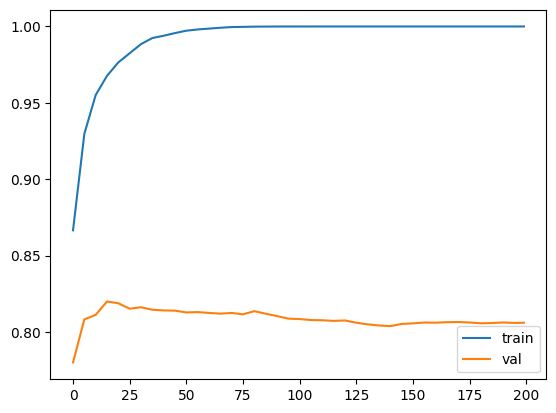

In [113]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

* **X-axis:** number of boosting rounds (trees added)
* **Y-axis:** AUC score
* **Blue line:** training AUC — shows how well the model fits the training data
* **Orange line:** validation AUC — shows how well the model generalizes to unseen data

From the graph:

* The **training AUC** (blue) quickly rises to **~1.0**, showing the model is learning training data extremely well.
* The **validation AUC** (orange) increases initially (good learning), but then **flattens and starts to decline** — this means **overfitting**.

Overfitting occurs when:

* The model continues to improve on the training data,
* But performance on unseen (validation) data starts to drop.

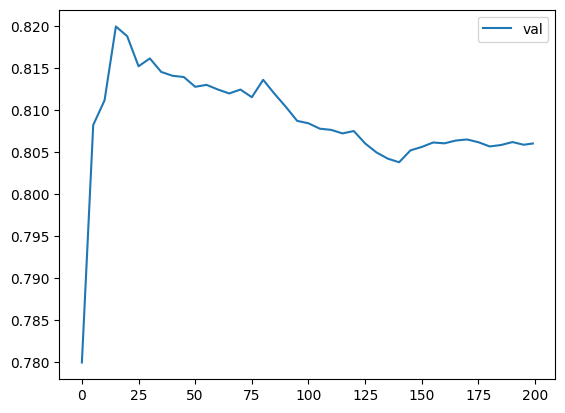

In [115]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

## XGBoost Parameter Tuning

In this section, we'll tune XGBoost hyperparameters to improve model performance:

* `eta` - learning rate
* `max_depth` - maximum tree depth
* `min_child_weight` - minimum sum of instance weight needed in a child


#### Understanding the Learning Rate (eta)

The **learning rate** controls how strongly each new tree influences the model.

When training a sequence of models:

* Each model corrects the mistakes of the previous one.
* **eta** defines the weight (importance) of these corrections.

For example:

* If `eta = 1.0`, each new model fully corrects the previous model’s predictions (large steps).
* If `eta = 0.3`, only 30% of the correction is applied (smaller steps).

Smaller learning rates slow down training but often lead to **better generalization**.

##### Experimenting with Different eta Values

We’ll compare the model’s performance for multiple learning rates:

`[1.0, 0.3, 0.1, 0.05, 0.01]`

For each value of `eta`, we:

* Train an XGBoost model.
* Capture its output and store it in a dictionary for analysis.
* Plot validation AUC over iterations.

In [157]:
scores = {}

In [170]:
%%capture output

xgb_params = {
    'eta': 1,                    # Learning rate (how fast the model learns)
    'max_depth': 6,                 # Maximum depth of each decision tree
    'min_child_weight': 1,          # Minimum samples in a leaf node

    'objective': 'binary:logistic', # Binary classification problem
    'eval_metric': 'auc',           # Use AUC as the evaluation metric
    
    'nthread': 8,                   # Use 8 CPU cores
    'seed': 1,                      # Random seed for reproducibility
    'verbosity': 1                  # Show warnings only
}


model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [171]:
key = 'eta=%s' % (xgb_params['eta'])  # Create a unique key name for this experiment
scores[key] = parse_xgb_output(output)
key

'eta=1'

In [172]:
scores.keys()

dict_keys(['eta=0.01', 'eta=0.05', 'eta=0.1', 'eta=0.3', 'eta=1'])

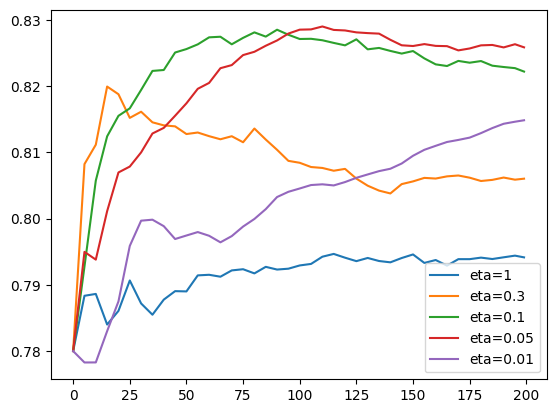

In [174]:
etas = ['eta=1', 'eta=0.3', 'eta=0.1', 'eta=0.05', 'eta=0.01']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)

plt.legend()


From these results, **eta = 0.1** provides the best balance between speed and performance.

Therefore, we’ll use `eta = 0.1` for further tuning.

### Tuning `max_depth`

Next, we tune the **max_depth** parameter, which controls how deep each decision tree can grow.

Deeper trees capture more complex relationships but are also more likely to overfit.

We test the following values:

`[3, 4, 6, 10]`

In [175]:
scores = {}

In [186]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [187]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key

'max_depth=3'

In [188]:
scores.keys()

dict_keys(['max_depth=10', 'max_depth=6', 'max_depth=4', 'max_depth=3'])

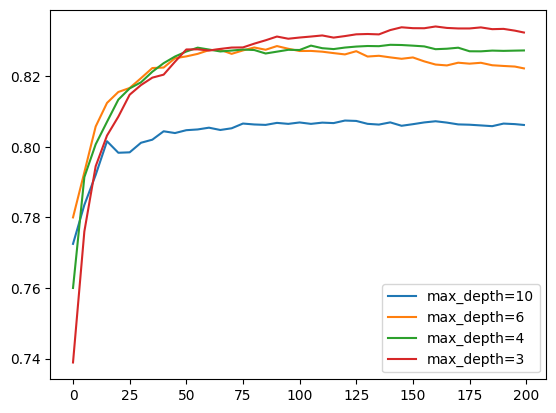

In [189]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.legend()

* **max_depth = 10** learns quickly but stagnates early and overfits.
* **max_depth = 6** performs reasonably well but declines faster.
* **max_depth = 4** improves more gradually but plateaus after 75 iterations.
* **max_depth = 3** grows slowly yet achieves the best long-term AUC (~0.835).

Although shallow trees (depth 3) require more iterations, they generalize better.

Thus, we select **max_depth = 3** as the optimal value.


### Tuning `min_child_weight`

We now adjust the **`min_child_weight`** parameter, which controls the minimum number of samples required in a leaf node.

This is similar to **`min_samples_leaf`** in Random Forests and helps prevent overfitting by limiting leaf growth.

We test the following values:

`[1, 10, 30]`

In [190]:
scores = {}

## Final Model Selection

Now that we've tuned the hyperparameters, let's train the final model on the full training set and evaluate it on the test set.


In [195]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [196]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=1'

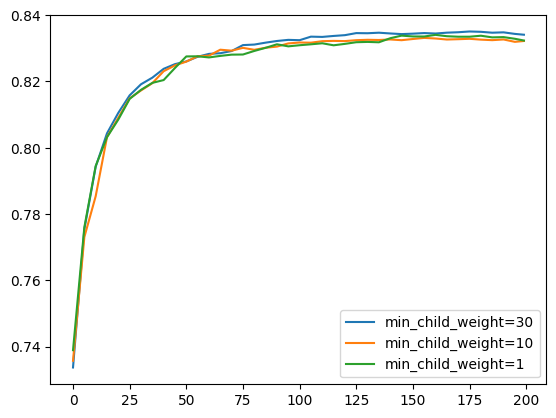

In [197]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.legend()

* Differences among the results are minor.
* `min_child_weight = 1` performs slightly better, though the improvement is marginal.

We’ll keep the default **min_child_weight = 1**.

### Training on Full Training Set

With our tuned parameters:

* **eta = 0.1**
* **max_depth = 3**
* **min_child_weight = 1**

We train the model for **175 iterations**, which provides a good balance between learning and overfitting.

This configuration represents our **final XGBoost model**.

In [198]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

### Additional Parameters Worth Exploring

Other parameters: https://xgboost.readthedocs.io/en/latest/parameter.html

XGBoost offers many more parameters to improve performance and control overfitting.

Two useful ones are:

* **colsample_bytree**
	- Similar to Random Forests — it determines the fraction of features (columns) each tree can use.
	- Try values like `0.3`, `0.6`, or `1.0`.

* **subsample**
	- Controls the fraction of training rows used per iteration (e.g., `0.5` means 50% of rows).
	- Try values between `0.3` and `0.7`.

Experimenting with these can further optimize performance and training time.

### Comparing All Models

So far, we have trained three different tree-based models:

1. **Decision Tree Model** – We selected the best parameters and visualized the resulting tree.
2. **Random Forest Model** – After experimentation, we found an optimal configuration with around 200 trees.
3. **XGBoost Model** – We tuned its parameters and achieved strong validation results.

Now, we will compare these three models on the **validation dataset** to determine which performs best.

In [199]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [200]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.785470804775859)

In [201]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [202]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

np.float64(0.8246258264512848)

In [203]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [204]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

np.float64(0.8334715797631446)

From these results, **XGBoost** is the top-performing model on the validation data.

### Training on Full Training Set

Since XGBoost performed best, we will use it as our **final model**.

To make the most of all available data, we will retrain it using the **entire training dataset** (`full_train`) and then evaluate it on the **test dataset**.

In [205]:
df_full_train = df_full_train.reset_index(drop=True)

In [206]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [207]:
del df_full_train['status']

In [210]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [212]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names_out().tolist())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out().tolist())

In [213]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [214]:
y_pred = model.predict(dtest)

In [215]:
roc_auc_score(y_test, y_pred)

np.float64(0.8299814280826938)

After training, we make predictions on the test data and compute the **AUC score**:

* **Test AUC:** 83%

This score is consistent with the validation results, confirming that the model **generalizes well** and hasn’t overfitted — despite using the validation data extensively during tuning.

## Summary

In this notebook, we've covered the fundamentals of decision trees and ensemble methods:

### Key Takeaways

* **Decision trees** learn if-then-else rules from data automatically.
* **Finding the best split**: The algorithm selects the split that minimizes impurity. This can lead to overfitting, so we control it by limiting the max depth and minimum samples per leaf.
* **Random forest** combines multiple decision trees. It requires a diverse set of models to make good predictions through feature and data subsampling.
* **Gradient boosting** trains models sequentially: each model tries to fix errors of the previous model. XGBoost is a highly optimized implementation of gradient boosting.
* **Parameter tuning** is crucial for achieving good performance with tree-based models. 

## Explore More

Here are some ideas for further exploration and improvement:

### Data Exploration and Feature Engineering

* For this dataset, we didn't do extensive EDA or feature engineering. You can explore the data more deeply to get additional insights.
* Try creating new features or transforming existing ones to improve model performance.

### Advanced Random Forest Techniques

* For random forest, there are more parameters that can be tuned. Check `max_features` and `bootstrap`.
* There's a variation of random forest called **"extremely randomized trees"**, or **"extra trees"**. Instead of selecting the best split among all possible thresholds, it selects a few thresholds randomly and picks the best one among them. Because of that, extra trees tend to avoid overfitting. In Scikit-Learn, they are implemented in `ExtraTreesClassifier`. Try it for this project.

### XGBoost Advanced Topics

* XGBoost can handle missing values - we don't have to do `fillna` for it. Check if not filling NA's helps improve performance.
* Experiment with other XGBoost parameters: `subsample` and `colsample_bytree`.
* Explore early stopping to prevent overfitting during training.

### Feature Importance

* When selecting the best split, decision trees find the most useful features. This information can be used for understanding which features are more important than others. 
* See examples for [random forest feature importance](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) (similar for plain decision trees) and for [XGBoost feature importance](https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost).

### Regression with Trees

* Trees can also be used for solving regression problems. Check `DecisionTreeRegressor`, `RandomForestRegressor`, and the `objective=reg:squarederror` parameter for XGBoost.